In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.special import loggamma
from scipy.stats import wasserstein_distance

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pywaffle import Waffle

from pathlib import Path

from earthquake import EarthquakeCatalog
from repeater import RepeaterCatalog, RepeaterSequences
from research_util import add_lettering

data_directory = Path('data/earthquake_catalogs/')

### To do:
- [X] Negative start time does not seem to work
- [ ] Maps the *remaining* repeating events
- [ ] Create all pair permutations are considered
- [X] Toggle bug
- [X] Remove actual repeaters in 'shadow time'
- [X] Remove events that are clearly in aftershocks sequences
  - should be done but there still is a suspicious number of very vigorous sequences in the dummy catalog
  - seems fixed, but more testing might be appropriate
- [ ] Make sure that the repeaters-sequences surrogates are representative (same number etc) 
- [ ] Make sure that the repeater mainshocks don't get included in the aftershocks
- [ ] plot cummulative moment comparisons
- [ ] compare locations
- [ ] query waveform for event
- [ ] show waveform comparison for events
- [x] impose a minimum radius to the surrogate search

### Potential repeater sets:
- Kiluea
- Kamaishi
- Mexico
- Based on scardec


In [2]:
earthquake_metadata = {
    "starttime": '1990-01-01',
    "endtime": '2024-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude": 1, 
} 

earthquakes = EarthquakeCatalog(
    filename=data_directory/'global_ALL.csv',
    kwargs=earthquake_metadata,
) # expect warnings about loading existing catalog and Nan values

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:176: UserWarning: Using existing data/earthquake_catalogs/global_ALL.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:182: UserWarning: 27913 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [3]:
pairs_config = dict(
    file_name = data_directory/"jgrb540690-sup-0002-2019jb018652-ts01.txt",
    min_time_delta_years = 0, 
)

surrogate_config = dict(
    min_distance_km = 3,            # avoid just selecting the same events or exact same geology
    max_distance_km = 150,          # selected to preserve some of the same structure with Mc and similar tectonic setting        
    max_magnitude_delta = 0.1,      # comparable to (event_pairs.catalog.Mag - event_pairs.catalog.Mag_2).abs().mean()  
    min_time_delta_days = 365,      # avoid the events being related to eachother
    max_time_delta_days = 40*365,   # avoid the events being related to eachother
    min_prior_time_delta = 20,      # avoid mainshocks occuring before the event
)

event_pairs = RepeaterCatalog(**pairs_config)
dummy_event_pairs = event_pairs.create_surrogate_catalog(other_catalog=earthquakes, **surrogate_config)

If this assertion fails, the search did not yield a surrogate for each pair. Rerun the cell above, or consider a larger search radius.

In [4]:
assert len(event_pairs) == len(dummy_event_pairs)

Here I also remove repeaters that are plausibly aftershocks of a large event. Note that a similar processing step occurs in the selection of surrogate events. I cannot think of a very clean way to code this up given the current structure... Here I first obtain earthquake sequences *prior* to the repeaters and check whether any are bigger than the main shock. I then make sure to remove those same corresponding surrogates for consistency.

In [5]:
# TODO: literal edge case where the surrogate could be on the edge of the 300 km radius
sequence_config = dict(
    sequence_duration_days = surrogate_config["min_prior_time_delta"],
    sequence_start_dt_days = -surrogate_config["min_prior_time_delta"],
    minimum_number_of_events = 0,                       
    radius_for_mc_determination = 200,                          # km
    radius_for_sequence = surrogate_config["max_distance_km"],  # km
    apply_same_completness = False,                           
)
repeater_seq = RepeaterSequences(event_pairs,earthquakes, **sequence_config)

bool_to_keep = []
for pair in repeater_seq.sequences:
    if (
        np.any(pair["catalog_1"].catalog.mag > pair["mag"]) or
        np.any(pair["catalog_2"].catalog.mag > pair["Mag_2"])
    ):
        bool_to_keep.append(False)
    else:
        bool_to_keep.append(True)
        
event_pairs.catalog = event_pairs.catalog.loc[bool_to_keep]
dummy_event_pairs.catalog = dummy_event_pairs.catalog.loc[bool_to_keep]

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(


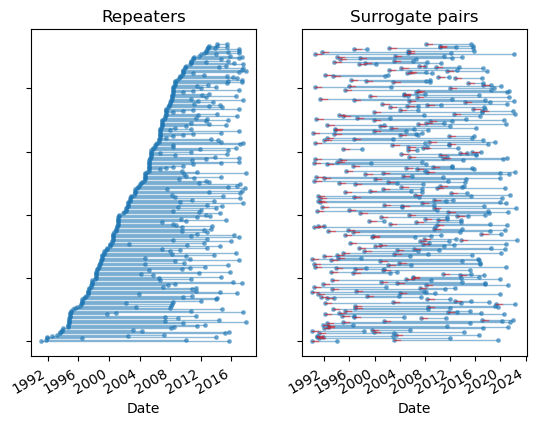

In [6]:
fig, AX = plt.subplots(1,2)
event_pairs.plot_pairs(ax=AX[0])
AX[0].set_title('Repeaters')
dummy_event_pairs.plot_pairs(ax=AX[1])
AX[1].set_title('Surrogate pairs')
fig.autofmt_xdate()

In [7]:
sequence_config = dict(
    sequence_duration_days = 60,
    sequence_start_dt_days = -30,
    minimum_number_of_events = 3,      # ensures that sequences comparisons are meaningful NOTE: This could introduce a collider bias
    radius_for_mc_determination = 200, # km
    radius_for_sequence = 50,          # km
    apply_same_completness = True,     # applies the higher completeness among the two sequences
)

repeater_seq = RepeaterSequences(event_pairs,earthquakes, **sequence_config)
dummy_repeater_seq = RepeaterSequences(dummy_event_pairs,earthquakes, **sequence_config)

sequences = repeater_seq.sequences
dummy_sequences = dummy_repeater_seq.sequences

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:357: UserWarning: Not enough events to determine the catalog completeness, setting Mc to 0
  warnings.warn(


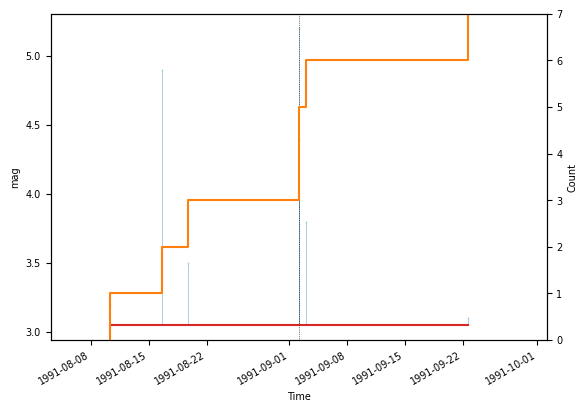

In [20]:
fig, ax = plt.subplots()
sequences[0]["catalog_1"].plot_time_series(ax=ax)
ax.axvline(sequences[0]["time"],ls=':',c='k',lw=0.5)
ax.set(
    xlim=np.mean(ax.get_xlim()) + (ax.get_xlim() - np.mean(ax.get_xlim())) # zoom in enhance cliché
)
fig.autofmt_xdate()

In [9]:
print('After processing...')
print(f'Number of dummy sequences: {len(dummy_sequences)}')
print(f'Number of sequences: {len(sequences)}')

After processing...
Number of dummy sequences: 126
Number of sequences: 217


In [38]:
def counting_measure_distance(t1,t2,T):
    
    n1, n2 = len(t1), len(t2)
    sorted_indices = np.argsort([n1, n2])
    
    t = [t1, t2][sorted_indices[0]]
    u = [t1, t2][sorted_indices[1]]
    
    return (
        np.sum(np.abs(t-u[:len(t)])) +
        np.sum(T-u[len(t):])
    )/max([n1,n2,1]) # appendix E.2 of Shchur et al., 2020

In [39]:
def calculate_spread(time_array, pair, method='counting measure distance'):
    
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    
    t1 = ((seq1.catalog.time - seq1.start_time)/np.timedelta64(1,'D')).values
    t2 = ((seq2.catalog.time - seq2.start_time)/np.timedelta64(1,'D')).values
    
    N1 = np.array([np.sum(t1 < t) for t in time_array])
    N2 = np.array([np.sum(t2 < t) for t in time_array])

    if method == 'difference':
        N2byN1 = np.abs(N1-N2)
    elif method == 'absolute relative difference':
        N2byN1 = np.abs(N1-N2)/N1
    elif method == 'log relative difference':
        N2byN1 = np.log10(np.abs(N1-N2)/N1)
    elif method == 'relative difference':
        N2byN1 = (N1-N2)/N1
    elif method == 'relative productivity':
        N2byN1 = np.log10(N2/N1)
    elif method == 'poisson':
        N2byN1 = (
            (N2+N1+1) * -np.log(2) 
            + loggamma(N2+N1) 
            - loggamma(N2) 
            - loggamma(N2)
        ) # avoids overflow
    elif method == 'counting measure distance':
        N2byN1 = [counting_measure_distance(t1[t1<Ti], t2[t2<Ti], Ti) for Ti in time_array]
    return N2byN1

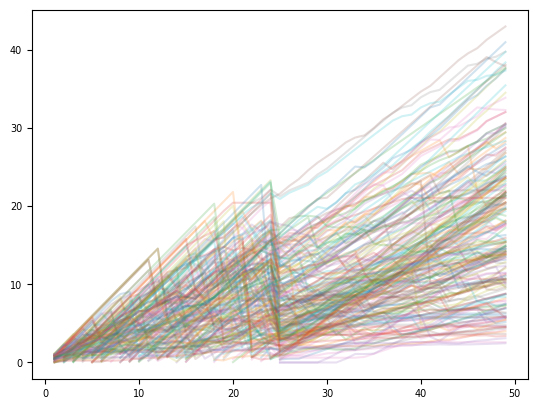

In [40]:
[plt.plot(s, alpha=0.2) for s in spread];

In [41]:
# time-dependent difference
difference_metric = 'counting measure distance'

spread = []
time_array = np.linspace(0,sequence_config['sequence_duration_days'],50)
for pair in sequences:
    N2byN1 = calculate_spread(time_array, pair, method=difference_metric)
    spread.append(N2byN1)
spread = np.array(spread) 
dummy_spread = np.array([calculate_spread(time_array, pair, method=difference_metric) for pair in dummy_sequences])

# final difference
final_spread = spread[:,-1][~np.isinf(spread[:,-1]) & ~np.isnan(spread[:,-1])]
final_dummy_spread = dummy_spread[:,-1][~np.isinf(dummy_spread[:,-1]) & ~np.isnan(dummy_spread[:,-1])]

# wasserstein difference
w_difference = []
nw_min = 5
for pair in sequences:
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    if min([len(seq1),len(seq2)]) < nw_min:
        w_difference.append(np.nan)
    else:
        count_for_comparison = min([len(seq1),len(seq2)])
        w_difference.append(
            wasserstein_distance(
                seq1.catalog.time[:count_for_comparison], 
                seq2.catalog.time[:count_for_comparison]
            )
        )

dummy_w_difference = []
for pair in dummy_sequences:
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    if min([len(seq1),len(seq2)]) < nw_min:
        dummy_w_difference.append(np.nan)
    else:
        count_for_comparison = min([len(seq1),len(seq2)])
        dummy_w_difference.append(wasserstein_distance(seq1.catalog.time[:count_for_comparison], seq2.catalog.time[:count_for_comparison]))   
        

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_86172/1611187200.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  seq1.catalog.time[:count_for_comparison],
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_86172/1611187200.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  seq2.catalog.time[:count_for_comparison]
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_86172/1611187200.py:41: FutureWarning: The behavior of `series[i:j]` with an integer

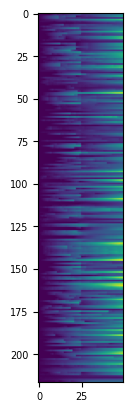

In [42]:
plt.imshow(spread)

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


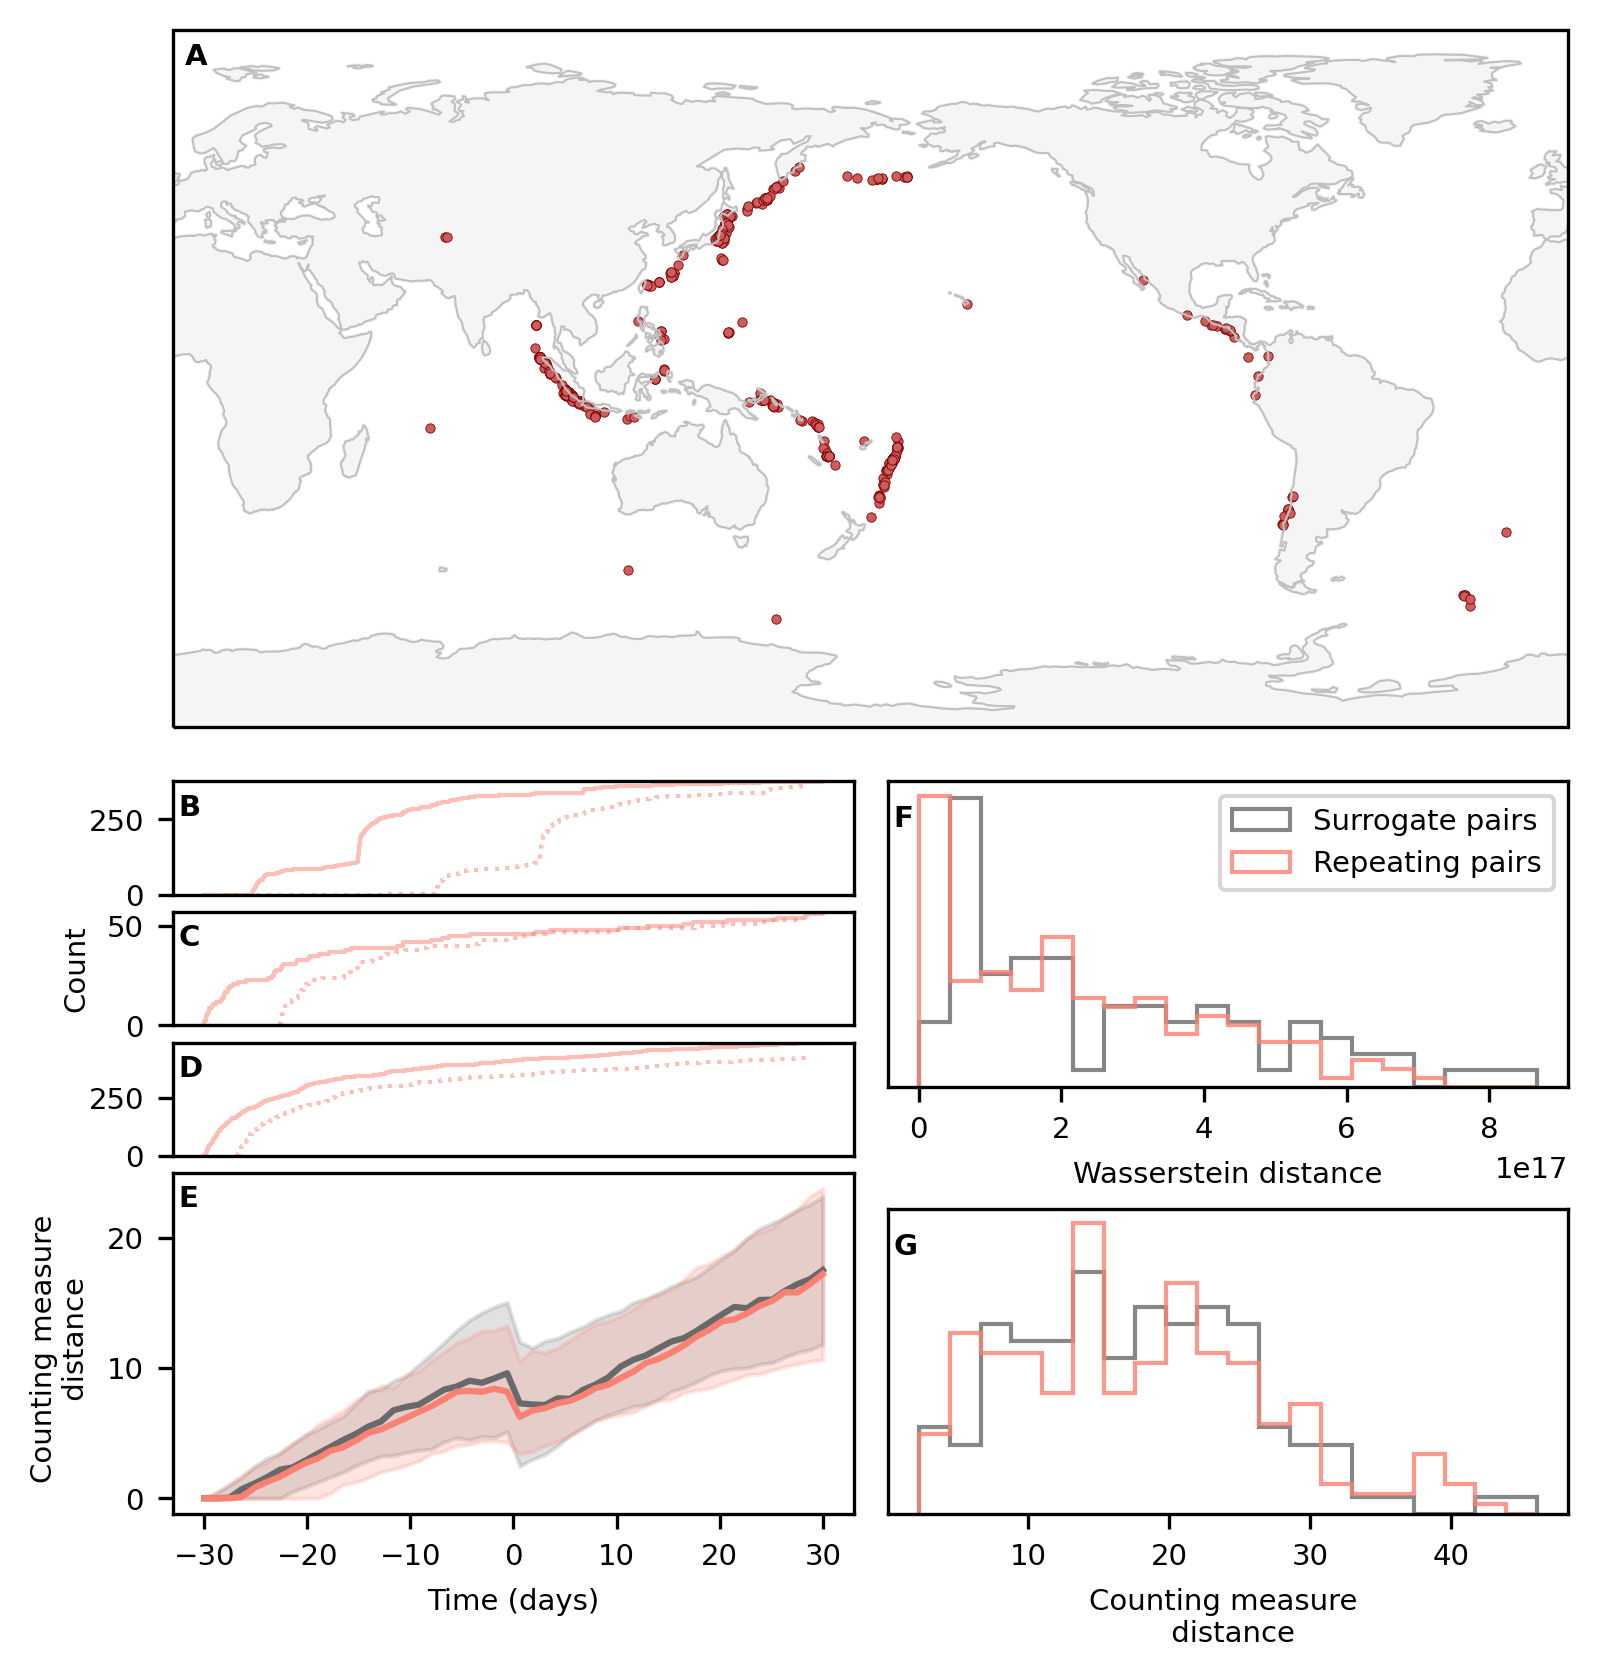

In [46]:
plt.rcParams.update({'font.size': 7})
quantile_range = [0.25,0.75]

data_color = "salmon"
dummy_color = "dimgray"

fig = plt.figure(figsize=(6,6.5), dpi=300)
gs = fig.add_gridspec(2,2,hspace=0.05,wspace=0.05)

# Top panel: the map
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=180))

event_pairs.plot_map(scatter_kwarg=dict(s=5, c='indianred',lw=0.2,edgecolor='maroon'),ax=ax)
ax.set(
    extent=[-180,180,-90,90],
)

gs_left = gs[1,0].subgridspec(4,1,hspace=0.1,height_ratios=[1,1,1,3])
gs_right = gs[1,1].subgridspec(2,1,hspace=0.4)

# middle left panel: compison of sequences
number_of_examples = 3
example_AX = [fig.add_subplot(gs_left[i,0]) for i in range(number_of_examples)]
for ax, pair in zip(
    example_AX,
    [sequences[i] for i in np.argsort(w_difference)[:number_of_examples]]):
    
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    
    N0 = len(seq1)
    for ls, seq in zip([':','-'],[seq1,seq2]):
        sns.ecdfplot(
            ((seq.catalog.time - seq.start_time)/np.timedelta64(1,'D')).values, 
            stat='count',
            color=data_color,
            alpha=0.5,
            ax=ax,
            ls=ls,
            lw=1,
        )
    ax.set(xticks=[],xticklabels=[]) 

[example_AX[i].set(ylabel=None) for i in [0,2]]

# Bottom left panel: comparison of spread over time: 
dt = time_array + sequence_config['sequence_start_dt_days']
ax = fig.add_subplot(gs_left[-1,0])
dummy_line = ax.plot(dt, np.median(dummy_spread, axis=0), c=dummy_color, label='Surrogate pairs')
dummy_fill = ax.fill_between(dt, *np.quantile(dummy_spread, quantile_range, axis=0), alpha=0.2, color=dummy_color)

data_line = ax.plot(dt, np.median(spread, axis=0), c=data_color, label='Repeating pairs')
data_fill = ax.fill_between(dt, *np.quantile(spread, quantile_range, axis=0), alpha=0.2, color=data_color)
ax.set(ylabel="Counting measure \n distance", xlabel="Time (days)")

# middle right panel: wassersein diffenrence
ax = fig.add_subplot(gs_right[0,0])
hist_kwargs = dict(
    bins=20,
    alpha=0.8,
    density=True,
    color=[data_color,dummy_color],
    label=['Repeating pairs','Surrogate pairs'],
    histtype='step',
)

ax.hist(
    [w_difference, dummy_w_difference], 
    **hist_kwargs,
)
ax.legend()

ax.set(
    xlabel="Wasserstein distance",
    yticks=[],
)

# bottom right panel: count measure histogram comparison
ax = fig.add_subplot(gs_right[1,0])
ax.hist([final_spread,final_dummy_spread], **hist_kwargs)
ax.set(xlabel="Counting measure \n distance", yticks=[])


add_lettering(
    fig.get_axes(), 
    position=[
        [0.008, 0.95],
        [0.008, 0.700],
        [0.008, 0.700],
        [0.008, 0.700],
        [0.008, 0.900],
        [0.008, 0.850],
        [0.008, 0.850]
    ]
)

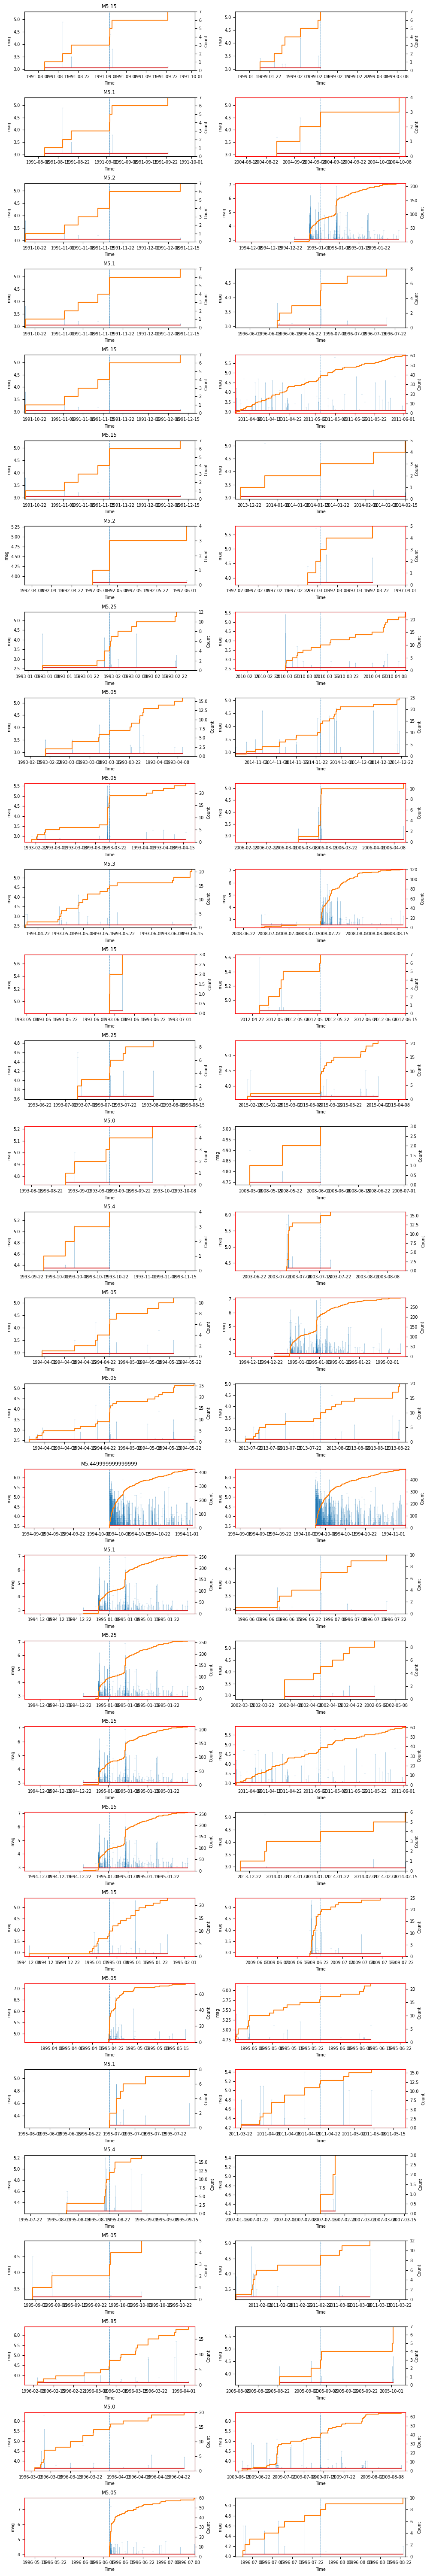

In [45]:
number_of_examples = 30
fig, AX = plt.subplots(number_of_examples,2,figsize=(10,number_of_examples*2))

for i, pair in enumerate(sequences[:number_of_examples]):
    
    pair["catalog_1"].plot_time_series(ax=AX[i,0])
    AX[i,0].axvline(pair['time'], ls='--',lw=0.5)
    if np.any(pair["mag"] < pair["catalog_1"].catalog.mag):
        for spine in plt.gca().spines.values():
            spine.set_edgecolor('red')

    pair["catalog_2"].plot_time_series(ax=AX[i,1])
    if np.any(pair["Mag_2"] < pair["catalog_2"].catalog.mag):
        for spine in plt.gca().spines.values():
            spine.set_edgecolor('red')
    AX[i,1].axvline(pair['Datetime_2'], ls='--',lw=0.5)
    AX[i,0].set(
        title= f"M{(pair['mag'] + pair['Mag_2'])/2}",
    )

plt.tight_layout()


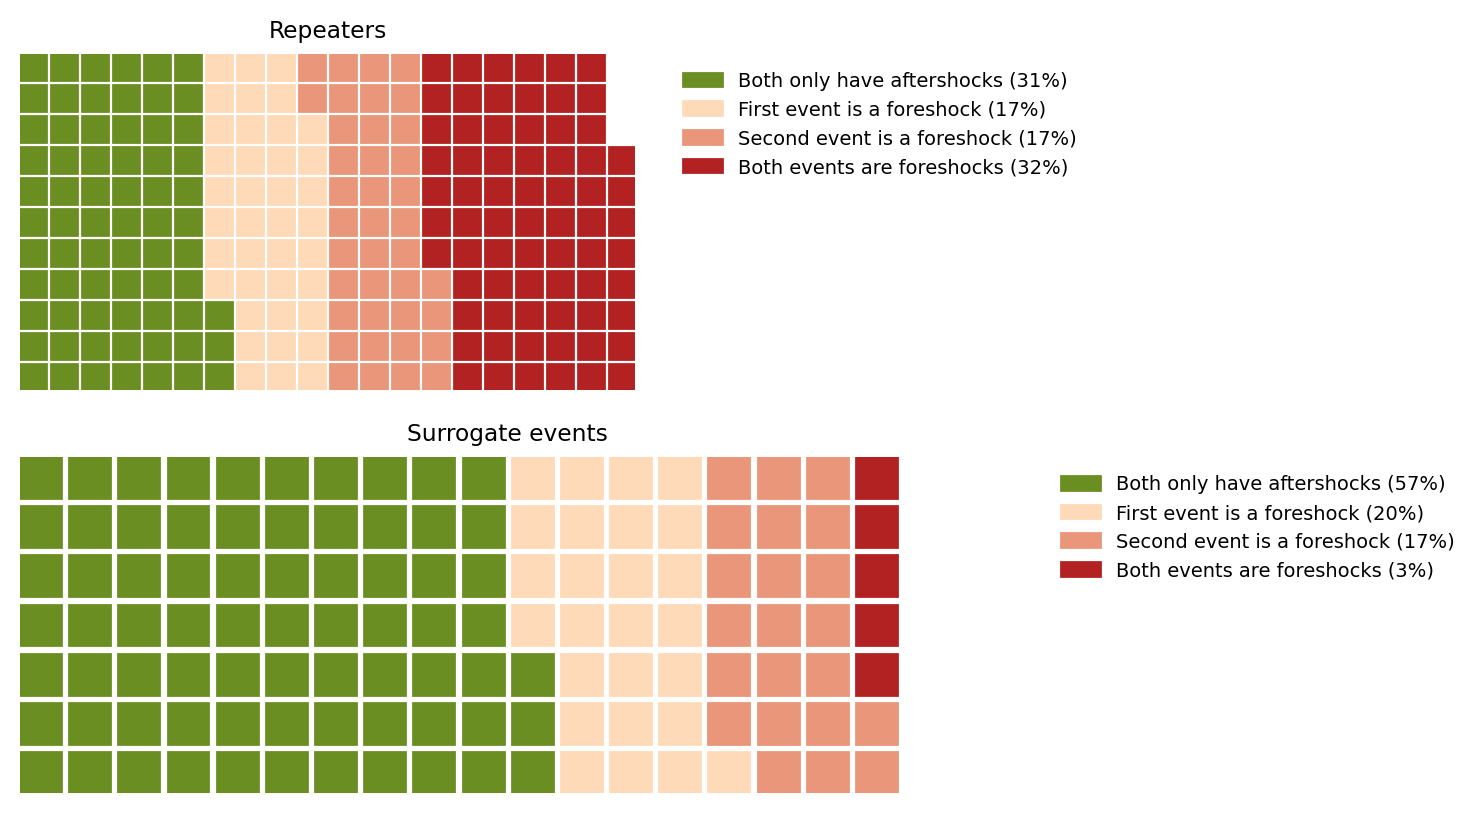

In [15]:
def has_bigger_aftershocks(sequences, mag_key, catalog_key, delta=0):
    return np.array([np.any((s[mag_key] + delta) < s[catalog_key].catalog.mag) for s in sequences])

first = has_bigger_aftershocks(repeater_seq.sequences, "mag", "catalog_1")
second = has_bigger_aftershocks(repeater_seq.sequences, "Mag_2", "catalog_2")

dummy_first = has_bigger_aftershocks(dummy_repeater_seq.sequences, "mag", "catalog_1")
dummy_second = has_bigger_aftershocks(dummy_repeater_seq.sequences, "Mag_2", "catalog_2")


def get_categories(a,b):
    return {
        "Both only have aftershocks": sum(~a & ~b),
        "First event is a foreshock": sum(a & ~b),
        "Second event is a foreshock": sum(~a & b),
        "Both events are foreshocks": sum(a & b),
    }

fig, AX = plt.subplots(2,1, dpi=200)

waffle_kwargs = dict(
    columns=20,
    colors=['olivedrab','peachpuff','darksalmon','firebrick'],
    legend={
        'loc': 'upper left', 'bbox_to_anchor': (1.05, 1),
        'framealpha': 0,
    }
)

AX[0].set_title("Repeaters")
data = get_categories(first,second)
Waffle.make_waffle(
    ax=AX[0],
    values=data,
    labels=[f"{k} ({int(v / sum(data.values()) * 100)}%)" for k, v in data.items()],
    **waffle_kwargs,
)

AX[1].set_title("Surrogate events")
data = get_categories(dummy_first,dummy_second)
Waffle.make_waffle(
    values=data,
    ax=AX[1],
    labels=[f"{k} ({int(v / sum(data.values()) * 100)}%)" for k, v in data.items()],
    **waffle_kwargs,
)

for ax in AX:
    ax.set_aspect(aspect="equal")

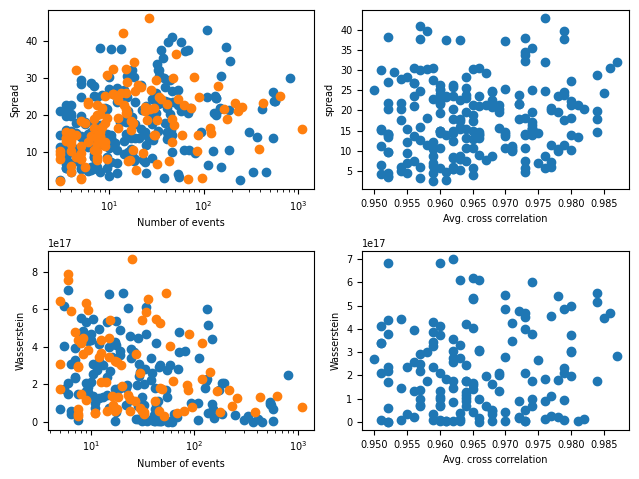

In [16]:
fig,AX = plt.subplots(2,2)
ax = AX[0,0]
ax.scatter(
    [
        np.mean(
            [len(s["catalog_1"]), len(s["catalog_2"])]
        ) for s in sequences
    ],
    final_spread,
)

ax.scatter(
    [
        np.mean(
            [len(s["catalog_1"]), len(s["catalog_2"])]
        ) for s in dummy_sequences
    ],
    final_dummy_spread,
)
ax.set(xscale='log', xlabel='Number of events', ylabel='Spread')

ax = AX[0,1]
ax.scatter(
    [s["Avg_CC"] for s in sequences],
    final_spread,
)

ax.set(ylabel='spread', xlabel='Avg. cross correlation')

ax = AX[1,0]
ax.scatter(
    [
        np.mean(
            [len(s["catalog_1"]), len(s["catalog_2"])]
        ) for s in sequences
    ],
    w_difference,
)

ax.scatter(
    [
        np.mean(
            [len(s["catalog_1"]), len(s["catalog_2"])]
        ) for s in dummy_sequences
    ],
    dummy_w_difference,
)
ax.set(xscale='log', xlabel='Number of events', ylabel='Wasserstein')

ax = AX[1,1]
ax.scatter(
    [s["Avg_CC"] for s in sequences],
    w_difference,
)

ax.set(ylabel='Wasserstein', xlabel='Avg. cross correlation')

plt.tight_layout()
